<div style="text-align: center;">
  <h2><strong></strong></h2>
</div>

<center>

## **Estadística No Paramétrica**
## **Taller 2**

**Autor:** Sebastian Carvalho Salazar  
**Email:** scarvalhos@eafit.edu.co  

**Autor:** Daniel Loaiza Lopez  
**Email:** dloaizal@eafit.edu.co  

**Autor:** Sebastian Ramirez Escobar  
**Email:** sramireze1@eafit.edu.co  

**Autor:** Asmec Duvan Urrea Uribe  
**Email:** adurreau@eafit.edu.co  

**Autor:** Hernan Felipe Sanchez Cardenas  
**Email:** hfsanchezc@eafit.edu.co  

</center>

## Librerias
---

In [2]:
!pip install scikit-fda -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import ipywidgets as widgets
from sympy import symbols, simplify, lambdify, integrate
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import skfda as fda
from skfda.exploratory.visualization import Boxplot
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

## Punto 1

### A. Creación de la Tabla de Frecuencias

In [ ]:
file_path = '/content/Temperaturas.xlsx'
data = pd.ExcelFile(file_path)
temperatures_data = data.parse('Hoja3')

In [ ]:
alicante_temperatures = temperatures_data['alicante7']
temperature_freq = alicante_temperatures.value_counts().sort_index()

In [ ]:
# Definir los bins para la tabla de frecuencias
bins = np.arange(alicante_temperatures.min(), alicante_temperatures.max() + 2, 2)  # bins de tamaño 2 grados

# Crear la tabla de frecuencias
hist, bin_edges = np.histogram(alicante_temperatures, bins=bins, density=False)
freq_table = pd.DataFrame({'Temperature Range': [f"{int(bin_edges[i])} to {int(bin_edges[i+1]-1)}" for i in range(len(bin_edges)-1)],
                           'Frequency': hist}) #Crear los rangos con los bins

freq_table['Relative Frequency'] = freq_table['Frequency'] / freq_table['Frequency'].sum() # Frecuencia Relativa
freq_table

,Temperature Range,Frequency,Relative Frequency
0,-14 to -13,1,0.000183
1,-12 to -11,0,0.000000
2,-10 to -9,1,0.000183
3,-8 to -7,12,0.002190
4,-6 to -5,54,0.009856
5,-4 to -3,140,0.025552
6,-2 to -1,313,0.057127
7,0 to 1,529,0.096550
8,2 to 3,433,0.079029
9,4 to 5,480,0.087607


### B. Estimación de Densidad con Kernels

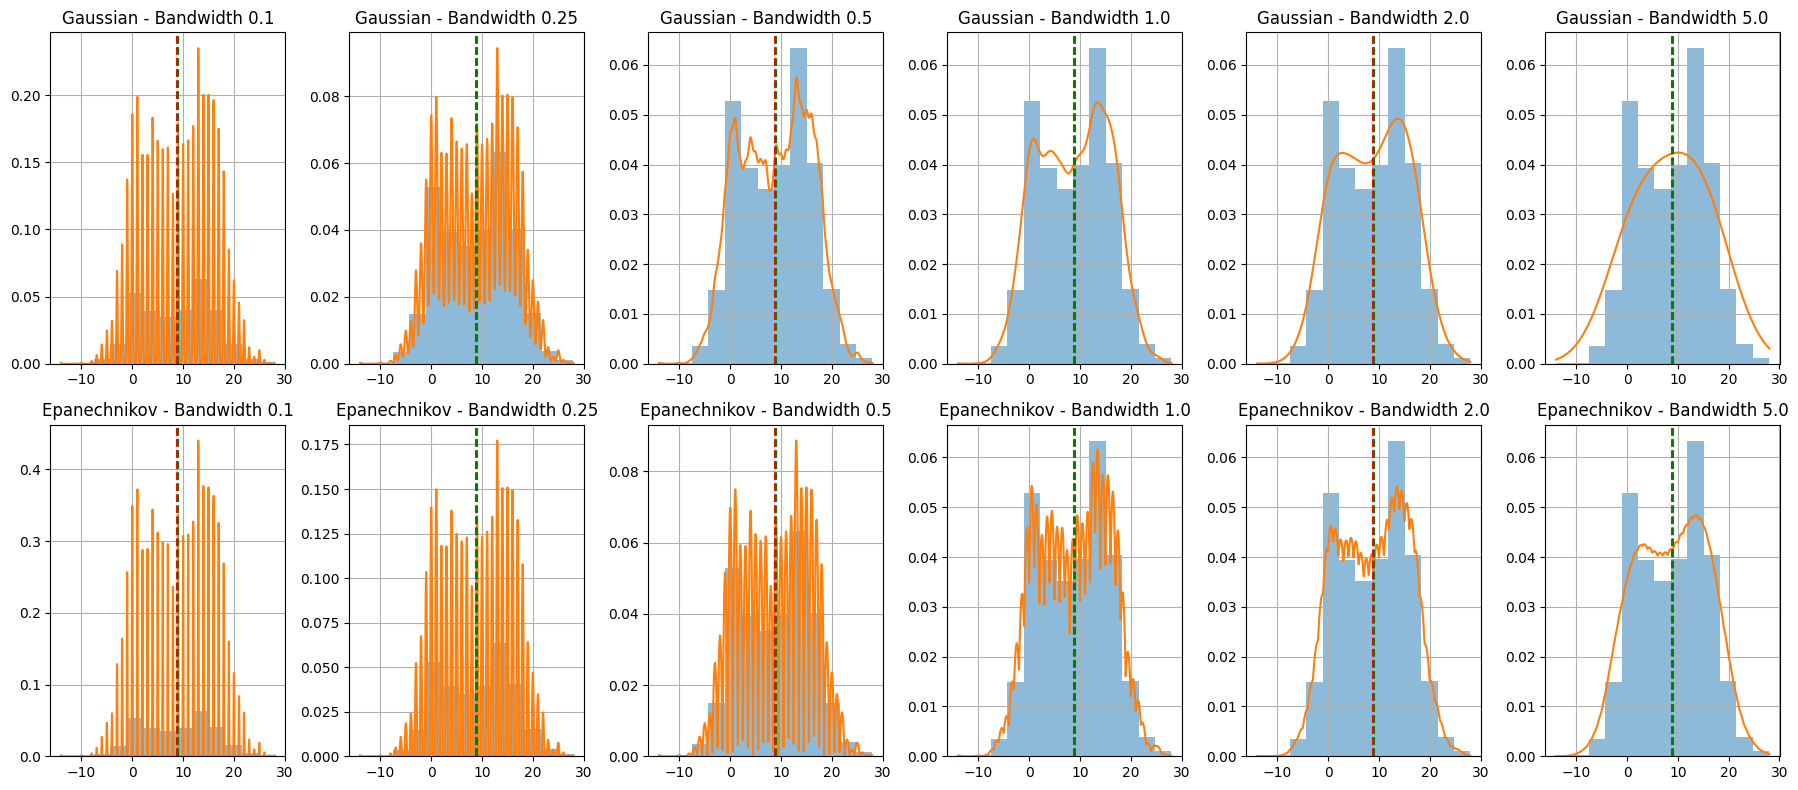

In [ ]:
X = alicante_temperatures.values.reshape(-1,1)

# Configuración de kernels y bandwiths
bandwidths = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0]
kernels = ['gaussian', 'epanechnikov']

mean = np.mean(X)
median = np.median(X)

# Crear subplots para cada combinación de kernel y bandwidth
fig, axs = plt.subplots(len(kernels), len(bandwidths), figsize=(18, 8))

for i, kernel in enumerate(kernels):
    for j, bandwidth in enumerate(bandwidths):
        # Ajustar el modelo de KDE
        kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X)

        # Crear el dominio para graficar la estimación
        X_plot = np.linspace(min(X)[0], max(X)[0], 1000)[:, np.newaxis]

        # Obtener log-likelihood para los valores en el dominio
        log_dens = kde.score_samples(X_plot)

        # Graficar el histograma y la estimación
        num_bins = int(1 + np.log2(len(X)))
        axs[i, j].hist(X, bins=num_bins, density=True, alpha=0.5)
        axs[i, j].plot(X_plot, np.exp(log_dens))
        axs[i, j].axvline(x=mean, color='red', linestyle='--', label='Promedio')
        axs[i, j].axvline(x=median, color='green', linestyle='--', label='Mediana')
        axs[i, j].set_title(f'{kernel.capitalize()} - Bandwidth {bandwidth}')
        axs[i, j].grid(True)

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

BW=1: La densidad es muy picuda y cada observación individual influye significativamente en el resultado.

BW=2: La densidad sigue mostrando variabilidad pero es más suavizada en comparación con BW=1.

BW=5: La densidad es mucho más suave y menos detallada con respecto a las calculadas anteriormente.

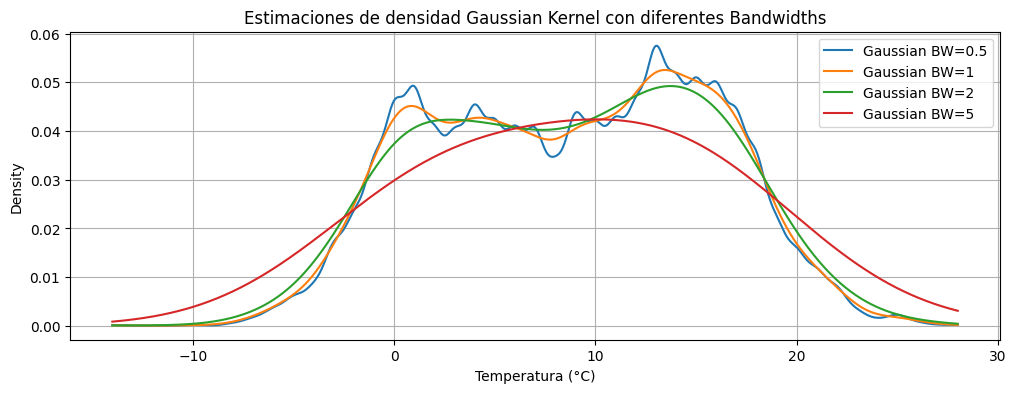

In [ ]:
# Función para estimar la densidad de kernel y plotear
def estimate_kde(bandwidth, kernel='gaussian'):
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde.fit(alicante_temperatures.to_numpy()[:, None])
    x_d = np.linspace(alicante_temperatures.min(), alicante_temperatures.max(), 1000)
    log_dens = kde.score_samples(x_d[:, None])
    return x_d, np.exp(log_dens)

# Estimaciones con kernel Gaussiano para diferentes anchos de banda (bandwith)
bandwidths = [0.5, 1, 2, 5]
kde_results = {bw: estimate_kde(bw, 'gaussian') for bw in bandwidths} #Estimar kde para cada uno de los anchos de banda (bandwith)

# Plotear las estimaciones
plt.figure(figsize=(12, 4))
for bw, (x, dens) in kde_results.items():
    plt.plot(x, dens, label=f'Gaussian BW={bw}')
plt.title('Estimaciones de densidad Gaussian Kernel con diferentes Bandwidths')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

### C. Probabilidad:

In [ ]:
#Calcular media, mediana y moda
media = alicante_temperatures.mean()
mediana = alicante_temperatures.median()
moda = alicante_temperatures.mode()[0]
media, mediana, moda

(8.776601569629495, 9.0, 13)

#### Usando Tabla de Frecuencias

In [ ]:
# Probabilidad acumulada de ser menor o igual a la media, mediana y moda
# Usando la tabla de frecuencias
def calculate_probability(value, freq_series):
    cumulative_probability = freq_series[freq_series.index <= value].sum() / freq_series.sum() #Probabilidad acumulada
    return cumulative_probability

# Probabilidades usando la tabla de frecuencias
prob_media_freq = calculate_probability(media, temperature_freq)
prob_mediana_freq = calculate_probability(mediana, temperature_freq)
prob_moda_freq = calculate_probability(moda, temperature_freq)

prob_media_freq, prob_mediana_freq, prob_moda_freq

(0.4718014236174484, 0.5167001277605402, 0.704143091805074)

#### Probabilidad usando la Estimación de Kernel (Forma 1):
Calcularemos estas probabilidades usando la estimación de Kernel con un ancho de banda seleccionado (por ejemplo, BW=2 para un equilibrio entre suavidad y detalle).

In [ ]:
# Función para calcular la probabilidad acumulada usando KDE
def calculate_probability_kde(value, x_values, density):
    cumulative_prob = np.trapz(density[x_values <= value], x=x_values[x_values <= value]) #Integrar
    return cumulative_prob

# Probabilidades usando el KDE con bandwith 0.5
x_values, density = kde_results[0.5]  # Usando resultados del Kernel Gaussiano
prob_media_kde = calculate_probability_kde(media, x_values, density)
prob_mediana_kde = calculate_probability_kde(mediana, x_values, density)
prob_moda_kde = calculate_probability_kde(moda, x_values, density)

prob_media_kde, prob_mediana_kde, prob_moda_kde

(0.4834594406466737, 0.49423645867852317, 0.6740834524553732)

Análisis de Sesgo en los Datos
Comparando las probabilidades calculadas a través de la tabla de frecuencias y la estimación de Kernel, ambas aproximaciones son consistentes entre sí. La probabilidad de temperaturas menores o iguales a la moda es más alta que la mediana y la media, lo que indica que los datos pueden tener un sesgo hacia temperaturas más bajas, especialmente considerando que la moda es mayor que la media y mediana.

Las temperaturas en Alicante pueden estar distribuidas de manera no uniforme, con una acumulación notable de valores en el rango medio a alto, posiblemente debido a extremos que no se presentan con tanta frecuencia pero que influyen considerablemente en la moda.

#### Probabilidad usando la Estimación de Kernel (Forma 2):

In [ ]:
temperaturas = alicante_temperatures

# a. Tabla de frecuencias
frecuencias = temperaturas.value_counts(normalize=True).reset_index()
frecuencias.columns = ['temperatura', 'frecuencia']

# b. Estimación utilizando al menos 2 Kernels
kde_default = gaussian_kde(temperaturas)
kde_small_bw = gaussian_kde(temperaturas, bw_method=0.1)
kde_large_bw = gaussian_kde(temperaturas, bw_method=1.0)

# c. Estimación de la probabilidad
media = np.mean(temperaturas)
mediana = np.median(temperaturas)
moda = temperaturas.mode()[0]

# Probabilidad de obtener un valor menor o igual a la media
prob_media_freq = frecuencias[frecuencias['temperatura'] <= media]['frecuencia'].sum()
prob_media_kde_default = kde_default.integrate_box(-np.inf, media)
prob_media_kde_small_bw = kde_small_bw.integrate_box(-np.inf, media)
prob_media_kde_large_bw = kde_large_bw.integrate_box(-np.inf, media)

# Probabilidad de obtener un valor menor o igual a la mediana
prob_mediana_freq = frecuencias[frecuencias['temperatura'] <= mediana]['frecuencia'].sum()
prob_mediana_kde_default = kde_default.integrate_box(-np.inf, mediana)
prob_mediana_kde_small_bw = kde_small_bw.integrate_box(-np.inf, mediana)
prob_mediana_kde_large_bw = kde_large_bw.integrate_box(-np.inf, mediana)

# Probabilidad de obtener un valor menor o igual a la moda
prob_moda_freq = frecuencias[frecuencias['temperatura'] <= moda]['frecuencia'].sum()
prob_moda_kde_default = kde_default.integrate_box(-np.inf, moda)
prob_moda_kde_small_bw = kde_small_bw.integrate_box(-np.inf, moda)
prob_moda_kde_large_bw = kde_large_bw.integrate_box(-np.inf, moda)

# Imprimir resultados
print("Probabilidad de obtener un valor menor o igual a la media:")
print("Tabla de frecuencias:", prob_media_freq)
print("KDE (ancho de banda predeterminado):", prob_media_kde_default)
print("KDE (ancho de banda pequeño):", prob_media_kde_small_bw)
print("KDE (ancho de banda grande):", prob_media_kde_large_bw)
print("\nProbabilidad de obtener un valor menor o igual a la mediana:")
print("Tabla de frecuencias:", prob_mediana_freq)
print("KDE (ancho de banda predeterminado):", prob_mediana_kde_default)
print("KDE (ancho de banda pequeño):", prob_mediana_kde_small_bw)
print("KDE (ancho de banda grande):", prob_mediana_kde_large_bw)
print("\nProbabilidad de obtener un valor menor o igual a la moda:")
print("Tabla de frecuencias:", prob_moda_freq)
print("KDE (ancho de banda predeterminado):", prob_moda_kde_default)
print("KDE (ancho de banda pequeño):", prob_moda_kde_small_bw)
print("KDE (ancho de banda grande):", prob_moda_kde_large_bw)

Probabilidad de obtener un valor menor o igual a la media:
Tabla de frecuencias: 0.47180142361744837
KDE (ancho de banda predeterminado): 0.48726455249636724
KDE (ancho de banda pequeño): 0.4857691965220906
KDE (ancho de banda grande): 0.4977343501535457

Probabilidad de obtener un valor menor o igual a la mediana:
Tabla de frecuencias: 0.5167001277605402
KDE (ancho de banda predeterminado): 0.49624205042375336
KDE (ancho de banda pequeño): 0.4949190352378796
KDE (ancho de banda grande): 0.5064476120420791

Probabilidad de obtener un valor menor o igual a la moda:
Tabla de frecuencias: 0.7041430918050738
KDE (ancho de banda predeterminado): 0.6761312236661171
KDE (ancho de banda pequeño): 0.6749639713581851
KDE (ancho de banda grande): 0.6595160555504009


# Punto 2
---

Usaremos la densidad estimada para simular 1000 datos y compararemos esta simulación con los datos reales.

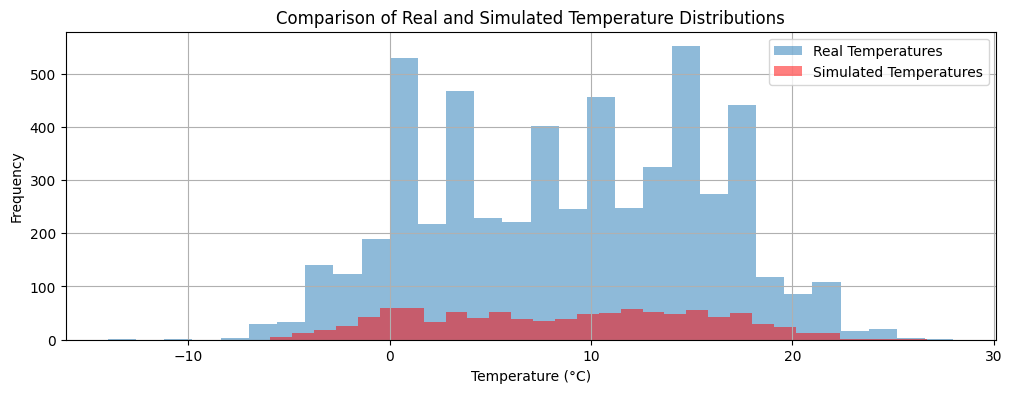

In [ ]:
# Corrección: Usar numpy.random.choice para generar muestras basadas en la densidad KDE con BW=2
def generate_samples_from_kde(x_values, density, n_samples=1000):
    probabilities = density / density.sum()
    samples = np.random.choice(x_values, size=n_samples, replace=True, p=probabilities)
    return samples

# Generar las muestras simuladas con la función corregida
simulated_temperatures = generate_samples_from_kde(x_values, density)

# Comparar visualmente los datos reales y simulados
plt.figure(figsize=(12, 4))
plt.hist(alicante_temperatures, bins=30, alpha=0.5, label='Real Temperatures')
plt.hist(simulated_temperatures, bins=30, alpha=0.5, label='Simulated Temperatures', color='red')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Comparison of Real and Simulated Temperature Distributions')
plt.legend()
plt.grid(True)
plt.show()

## Simulación Repetida 10000 veces

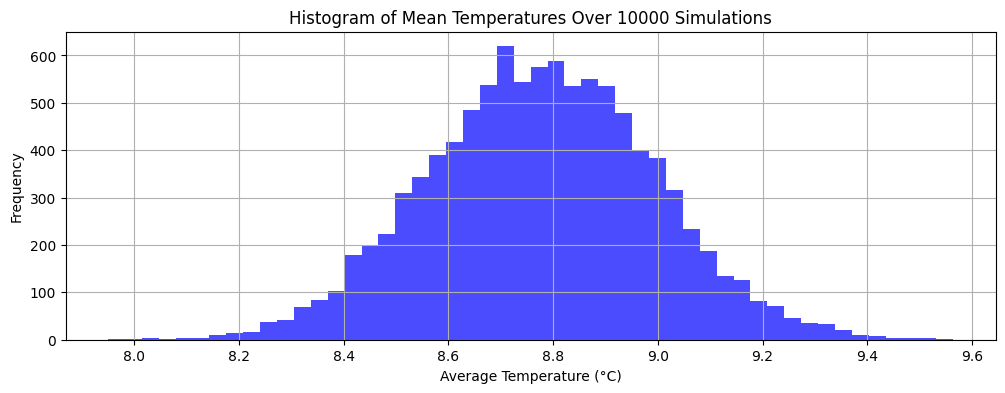

In [ ]:
# Simular 10000 veces, calcular el promedio de temperaturas en cada simulación
n_iterations = 10000
mean_temperatures = [generate_samples_from_kde(x_values, density).mean() for _ in range(n_iterations)]

# Histograma de los promedios calculados
plt.figure(figsize=(12, 4))
plt.hist(mean_temperatures, bins=50, color='blue', alpha=0.7)
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Temperatures Over 10000 Simulations')
plt.grid(True)
plt.show()

## Promedio de remuestreos de los datos reales

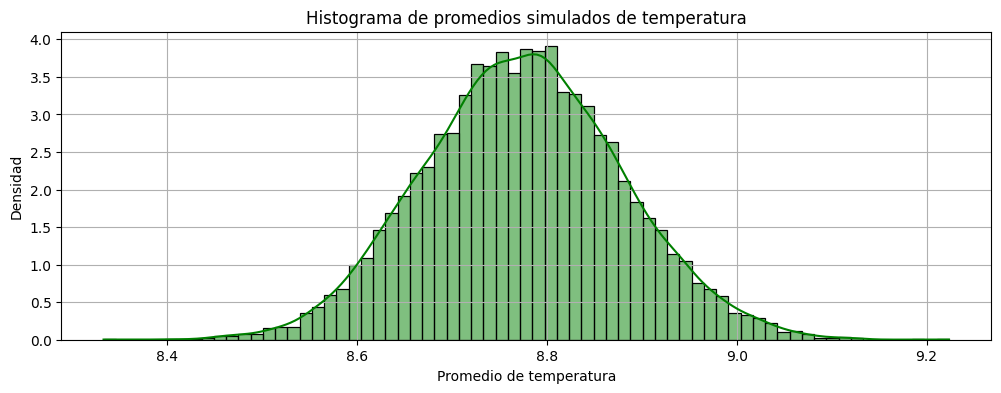

In [ ]:
promedios_simulados = [np.mean(np.random.choice(temperaturas, size=int(len(temperaturas)*0.8), replace=True)) for _ in range(10000)]

# Histograma de los promedios simulados
plt.figure(figsize=(12, 4))
sns.histplot(promedios_simulados, kde=True, color='green', stat='density')
plt.title('Histograma de promedios simulados de temperatura')
plt.xlabel('Promedio de temperatura')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

# Punto 5

Modelo de regresión donde la variable explicativa (Y) es la provincia de Alicante, y las variables regresoras (X) son las demás provincias del conjunto de datos.

In [ ]:
# Cargar el archivo Excel en un DataFrame
data = pd.read_excel("Temperaturas.xlsx", sheet_name="Hoja3")
data = data.drop(columns=["ano1","mes2","dia3","fecha4",])

In [ ]:
# Seleccionar las variables de interés
y = data["alicante7"]
# Seleccionar el resto de provincias
X = data.drop(columns=["alicante7"])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)

(4383, 51) (4383,)


### 2. Correlación de X, Y

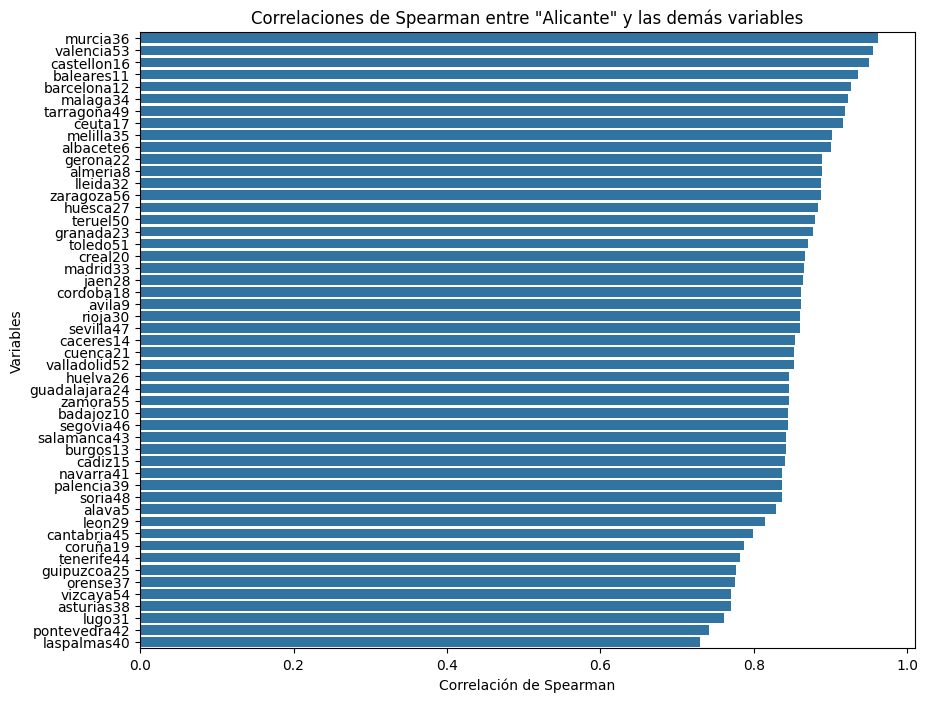

In [ ]:
# Calcular la correlación de Spearman
correlation_spearman = X.corrwith(y, method='spearman')

# Ordenar las correlaciones (sin tomar el valor absoluto)
correlation_spearman_sorted = correlation_spearman.sort_values(ascending=False)

# Visualización gráfica
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_spearman_sorted.values, y=correlation_spearman_sorted.index)
plt.title('Correlaciones de Spearman entre "Alicante" y las demás variables')
plt.xlabel('Correlación de Spearman')
plt.ylabel('Variables')
plt.show()

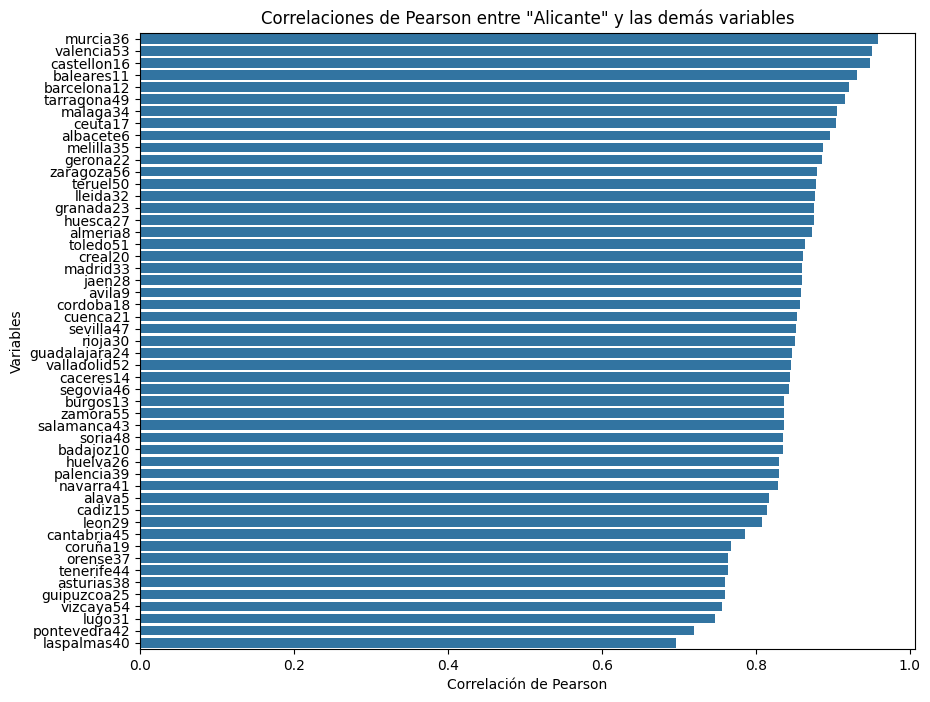

In [ ]:
# Calcular la correlación de Pearson
correlation_pearson = X.corrwith(y, method='pearson')

# Ordenar las correlaciones (sin tomar el valor absoluto)
correlation_pearson_sorted = correlation_pearson.sort_values(ascending=False)

# Visualización gráfica
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_pearson_sorted.values, y=correlation_pearson_sorted.index)
plt.title('Correlaciones de Pearson entre "Alicante" y las demás variables')
plt.xlabel('Correlación de Pearson')
plt.ylabel('Variables')
plt.show()

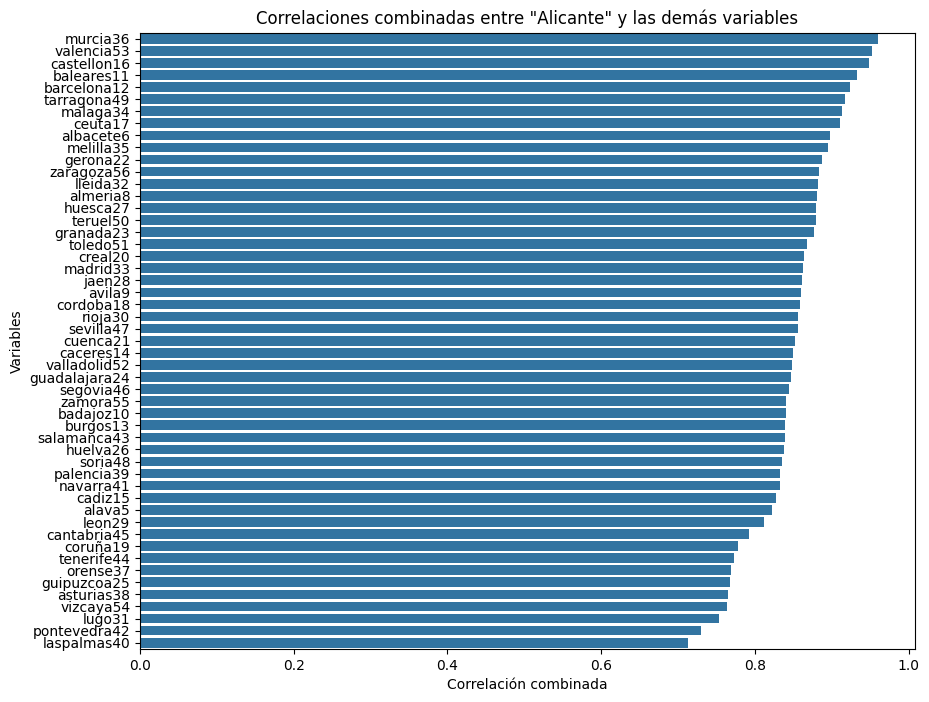

In [ ]:
# Combinar las correlaciones (promedio de Spearman y Pearson)
correlation_combined = (correlation_spearman + correlation_pearson) / 2

# Ordenar las correlaciones combinadas
correlation_combined_sorted = correlation_combined.sort_values(ascending=False)

# Visualización gráfica de las correlaciones combinadas
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_combined_sorted.values, y=correlation_combined_sorted.index)
plt.title('Correlaciones combinadas entre "Alicante" y las demás variables')
plt.xlabel('Correlación combinada')
plt.ylabel('Variables')
plt.show()

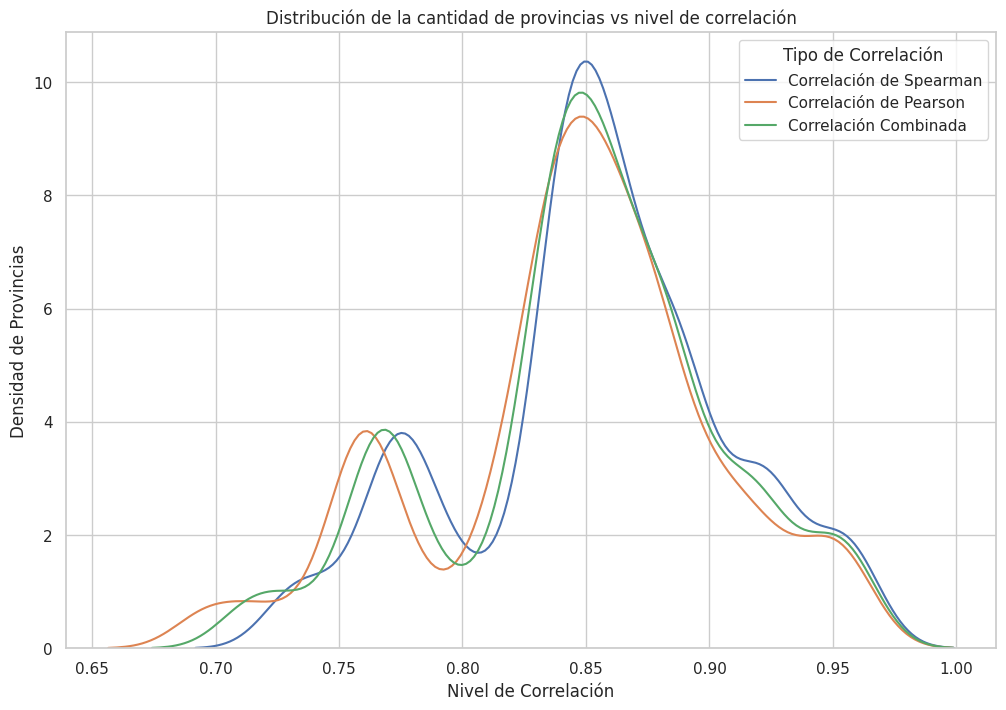

In [ ]:
# Estableciendo el estilo del gráfico
sns.set(style="whitegrid")

# Crear un objeto de figura y un conjunto de subtramas
plt.figure(figsize=(12, 8))

# Graficar la distribución de las correlaciones de Spearman, Pearson y Combinada
sns.kdeplot(correlation_spearman, label='Correlación de Spearman', bw_adjust=0.5)
sns.kdeplot(correlation_pearson, label='Correlación de Pearson', bw_adjust=0.5)
sns.kdeplot(correlation_combined, label='Correlación Combinada', bw_adjust=0.5)

# Añadir título y etiquetas a los ejes
plt.title('Distribución de la cantidad de provincias vs nivel de correlación')
plt.xlabel('Nivel de Correlación')
plt.ylabel('Densidad de Provincias')
plt.legend(title='Tipo de Correlación')

# Mostrar el gráfico
plt.show()

In [ ]:
# Obtener las provincias más correlacionadas basadas en un umbral de valor absoluto superior a 0.85
provincias_relevantes = correlation_combined_sorted[(correlation_combined_sorted.values) > 0.9]

# Mostrar las provincias relevantes
print(provincias_relevantes)

murcia36       0.960284
valencia53     0.952818
castellon16    0.948760
baleares11     0.933236
barcelona12    0.923415
tarragona49    0.917461
malaga34       0.913420
ceuta17        0.910598
dtype: float64


In [ ]:
# Seleccionar 2 provincias para utilizar en KernelReg
relevant_correlations = correlation_combined_sorted[(correlation_combined_sorted.values) > 0.95]

# Mostrar las provincias relevantes
print(relevant_correlations)

# Seleccionar los datos de las 2 provincias para KernelReg
X_10 = data[relevant_correlations.index]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train10, X_test10, y_train10, y_test10 = train_test_split(X_10, y, test_size=0.2, random_state=42)


murcia36      0.960284
valencia53    0.952818
dtype: float64


### 2 . Modelo Robusto RLM

In [ ]:
# Ajuste de modelos

# Método Robusto1
rlm_model_Hampel = sm.RLM(y_train,
                   X_train,
                   M=sm.robust.norms.Hampel()).fit()


### Otras normas
# AndrewWave()
# Hampel()
# HuberT()
# RamsayE()
# TrimmedMean([c])

# # Predicciones sobre los datos de prueba
y_pred_rlm_Hampel = rlm_model_Hampel.predict(X_test)

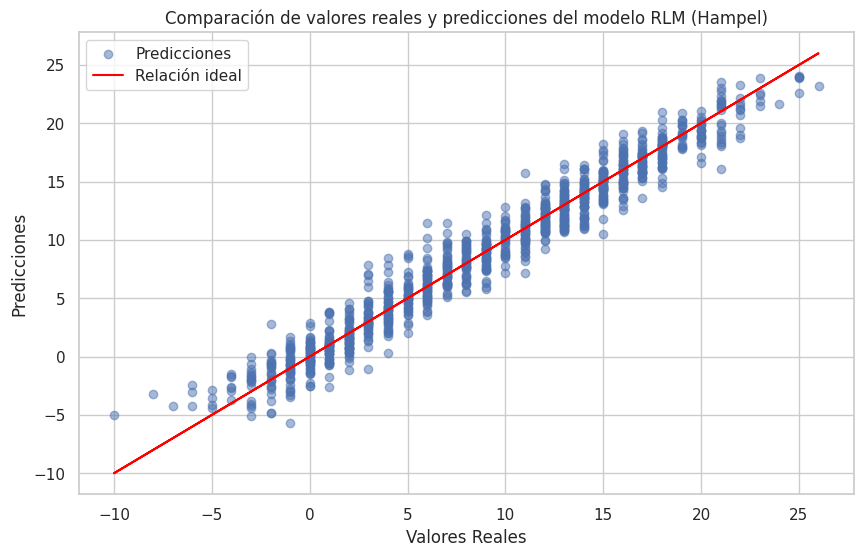

In [ ]:
# Gráfica de dispersión de los valores reales vs. predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rlm_Hampel, alpha=0.5, label='Predicciones')
plt.plot(y_test, y_test, color='red', label='Relación ideal')  # Línea ideal

# Añadir etiquetas y leyenda
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales y predicciones del modelo RLM (Hampel)')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


In [ ]:
# Crear y entrenar un modelo de regresión kernel
kernel_model = KernelReg(endog=y_train10, exog=X_train10, var_type='c'*X_train10.shape[1], reg_type = 'll')


In [ ]:
y_pred_kernelReg = kernel_model.fit()[0]


In [ ]:
# Calcular el MSE
mse = mean_squared_error(y_train10, y_pred_kernelReg)

# Calcular el R2
r2 = r2_score(y_train10, y_pred_kernelReg)

print(f"MSE: {mse}")
print(f"R^2: {r2}")


MSE: 2.693667214512897
R^2: 0.9428325306050978


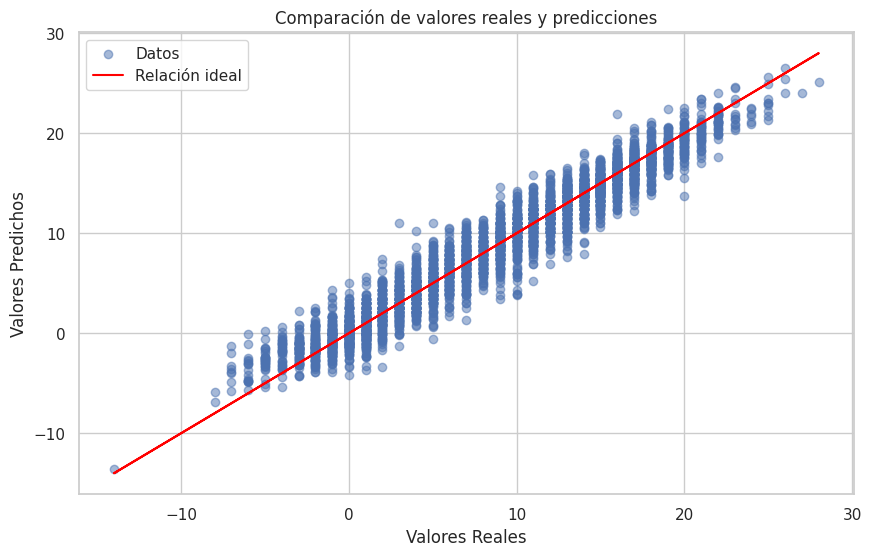

In [ ]:
# Gráfica de dispersión de los valores reales vs. predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_train10, y_pred_kernelReg, alpha=0.5, label='Datos')
plt.plot(y_train10, y_train10, color='red', label='Relación ideal')  # Línea ideal

# Añadir etiquetas y leyenda
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación de valores reales y predicciones')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()



### 4. Modelo Robusto: RANSAC

In [ ]:
# Crear un modelo RANSAC
ransac_model = RANSACRegressor(random_state=0)

# Entrenar el modelo RANSAC con los datos de entrenamiento
ransac_model.fit(X_train, y_train)

y_pred_ransac = ransac_model.predict(X_test)

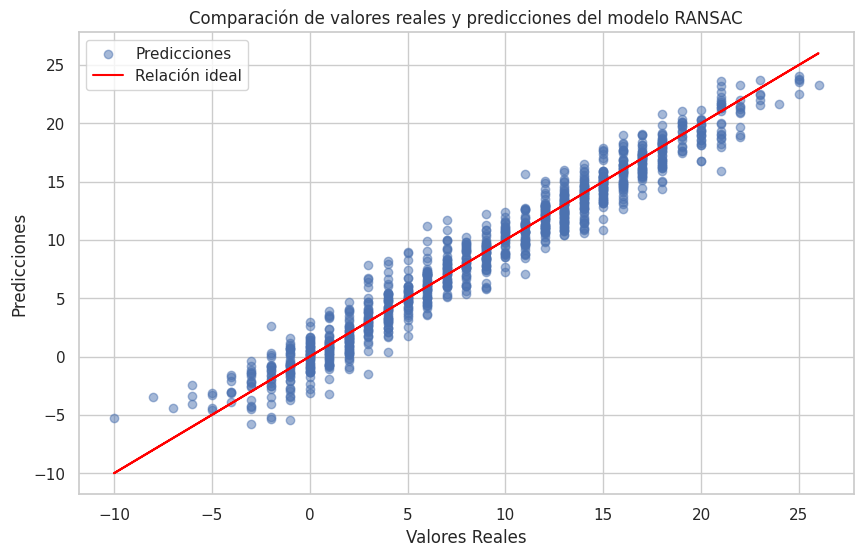

In [ ]:
# Gráfica de dispersión de los valores reales vs. predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ransac, alpha=0.5, label='Predicciones')
plt.plot(y_test, y_test, color='red', label='Relación ideal')  # Línea ideal

# Añadir etiquetas y leyenda
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales y predicciones del modelo RANSAC')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

### 5. Métricas de todos los modelos

In [ ]:
# Evaluacion en test para todos los modelos

# Cálculo del coeficiente de determinación R^2
print('RLM_Hampel')
print(f'R2:{metrics.r2_score(y_test, y_pred_rlm_Hampel)}')
print(f'MSE:{metrics.mean_squared_error(y_test, y_pred_rlm_Hampel)}')
print('\n')
print('RANSAC')
print(f'R2:{metrics.r2_score(y_test, y_pred_ransac)}')
print(f'MSE:{metrics.mean_squared_error(y_test, y_pred_ransac)}')
print('\n')
print('KernelReg')
print(f'R2:{r2_score(y_train10, y_pred_kernelReg)}')
print(f'MSE:{mean_squared_error(y_train10, y_pred_kernelReg)}')

RLM_Hampel
R2:0.9565649760935544
MSE:2.0881983936109894


RANSAC
R2:0.9557862333623158
MSE:2.1256375193246346


KernelReg
R2:0.9428325306050978
MSE:2.693667214512897


# Punto 6

Encontrando la función teórica

In [ ]:
# Definir las variables
x, y = symbols('x y')
limite_superior = 2

# Definir la función a integrar
funcion = 3/16*(x**2 + y**2)

# Calcular la doble integral sobre los límites especificados
fx = integrate(funcion, (y, x, limite_superior))
fx

-0.25*x**3 + 0.375*x**2 + 0.5

In [ ]:
fyx = (y * (funcion/fx))
fyx

y*(0.1875*x**2 + 0.1875*y**2)/(-0.25*x**3 + 0.375*x**2 + 0.5)

In [ ]:
fyx = (y * (funcion/fx))
fyx

y*(0.1875*x**2 + 0.1875*y**2)/(-0.25*x**3 + 0.375*x**2 + 0.5)

In [ ]:
# Definiendo f(x|y)
fyx = (y * (funcion/fx))

# Estimando la función E[Y|X]
EYX = integrate(fyx, (y, x, limite_superior))
print("Función del valor esperado")
simplify(EYX)


Función del valor esperado


(0.28125*x**3 + 0.5625*x**2 + 0.375*x + 0.75)/(0.5*x**2 + 0.25*x + 0.5)

Una vez obtenida la función, simulamos 1000 datos utilizando esta. Y para efectos de modelado no parametrico se se sumará ruido blanco con una desviación estandar de 0.1

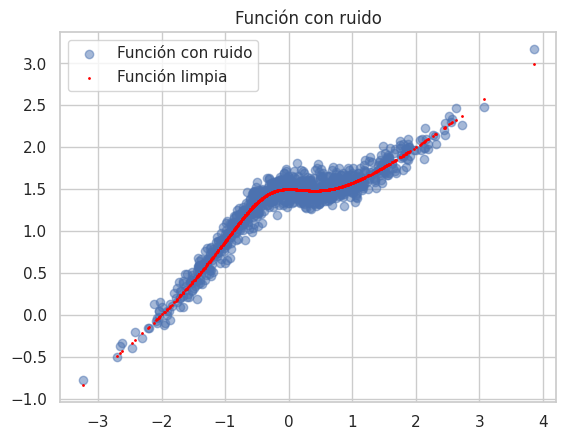

In [ ]:
np.random.seed(42)
# Simulando 1000 datos con esta función
funcion_numerica = lambdify(x, EYX, 'numpy')

# Generar 1000 puntos aleatorios para x
x_datos = np.random.normal(0, 1, 1000)

# Evaluar la función en esos puntos
y_datos = funcion_numerica(x_datos)

# Agregando ruido a la función
ruido = np.random.normal(0, 0.1, 1000)  # Ruido con media 0 y desviación estándar 0.5
y_datos_con_ruido = y_datos + ruido

# Función con ruido
plt.scatter(x_datos, y_datos_con_ruido, alpha=0.5, label='Función con ruido')
# Función limpia
plt.scatter(x_datos, y_datos, s=1, color='red', label='Función limpia')
plt.title('Función con ruido')
plt.legend()

Ahora que tenemos un conjunto de datos, probemos diferentes modelos sobre estos. Empezando por el modelo lineal tradicional

Coeficiente de Determinación (R²): 0.7807872503119196
Raíz del Error Cuadrático Medio (RMSE): 0.04457559955888898


,Modelo,R2,RMSE
0,Regresion Lineal,0.780787,0.044576


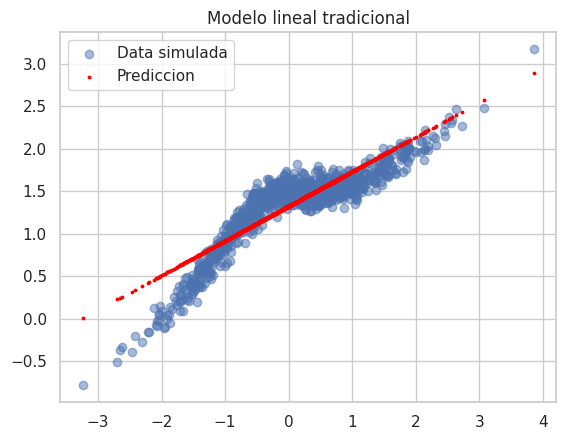

In [ ]:
# Modelo lineal tradicional
np.random.seed(42)
b1 = np.cov(x_datos, y_datos_con_ruido)[0,1]/np.cov(x_datos, y_datos_con_ruido)[0,0]
b0 = np.mean(y_datos_con_ruido) - b1*np.mean(x_datos)
pred_lineal = b0+b1*x_datos
plt.figure('Regresion tradicional')
plt.scatter(x_datos, y_datos_con_ruido, alpha=0.5, label='Data simulada')
plt.scatter(x_datos, (b0+b1*x_datos), s=3, color='red', label='Prediccion')
plt.title('Modelo lineal tradicional')
plt.legend()
# Calcular R^2
r2 = r2_score(y_datos_con_ruido, pred_lineal)
print(f"Coeficiente de Determinación (R²): {r2}")
# Calcular RMSE
rmse = mean_squared_error(y_datos_con_ruido, pred_lineal)
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")


resultados = pd.DataFrame([['Regresion Lineal', r2, rmse]], columns=['Modelo', 'R2', 'RMSE'])
resultados

Ahora, evaluemos un modelo no parametrico

Coeficiente de Determinación (R²): 0.9504396757201334
Raíz del Error Cuadrático Medio (RMSE): 0.010077795074654538


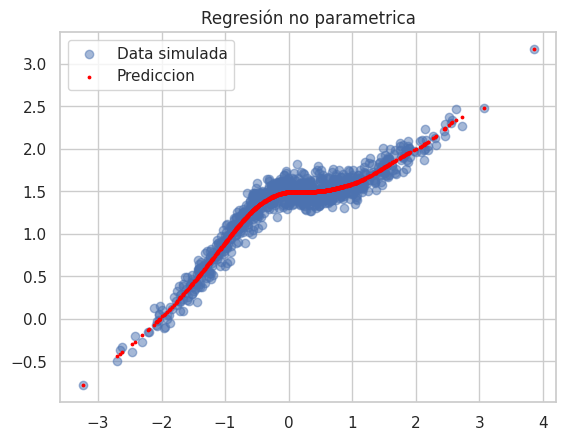

In [ ]:
# Modelo No Parametrico
np.random.seed(42)
### Local regression
plt.figure('Local regression')
pred_no_param, _ = KernelReg(endog = y_datos_con_ruido, exog = x_datos, var_type = 'c', reg_type = 'll').fit()
plt.scatter(x_datos, y_datos_con_ruido, alpha=0.5, label='Data simulada')
plt.scatter(x_datos, pred_no_param, s=3, color='red', label='Prediccion')
plt.title('Regresión no parametrica')
plt.legend()
# Calcular R^2
r2 = r2_score(y_datos_con_ruido, pred_no_param)
print(f"Coeficiente de Determinación (R²): {r2}")
# Calcular RMSE
rmse = mean_squared_error(y_datos_con_ruido, pred_no_param)
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")

# Datos de la nueva fila
noparam = pd.DataFrame([['Regresion No Parametrica', r2, rmse]], columns=resultados.columns)


Y ahora ensayemos con un modelo robusto

Coeficiente de Determinación (R²): 0.6695430258398292
Raíz del Error Cuadrático Medio (RMSE): 0.0671964462494348


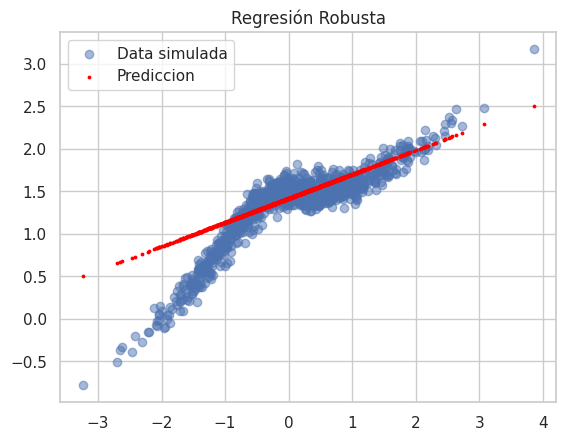

In [ ]:
# Modelo Robusto RANSAC
np.random.seed(42)
# Definiendo el modelo
model_ransac = RANSACRegressor()

# Haciendo reshape a los datos
x_datos_reshape = x_datos.reshape(-1, 1)
model_ransac.fit(x_datos_reshape, y_datos_con_ruido)
pred_ransac = model_ransac.predict(x_datos_reshape)
plt.scatter(x_datos_reshape, y_datos_con_ruido, alpha=0.5, label='Data simulada')
plt.scatter(x_datos_reshape, pred_ransac, s=3, color='red', label='Prediccion')
plt.title('Regresión Robusta')
plt.legend()
# Calcular R^2
r2 = r2_score(y_datos_con_ruido, pred_ransac)
print(f"Coeficiente de Determinación (R²): {r2}")
# Calcular RMSE
rmse = mean_squared_error(y_datos_con_ruido, pred_ransac)
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")


# Datos de la nueva fila
robusta = pd.DataFrame([['Regresion Robusta', r2, rmse]], columns=resultados.columns)

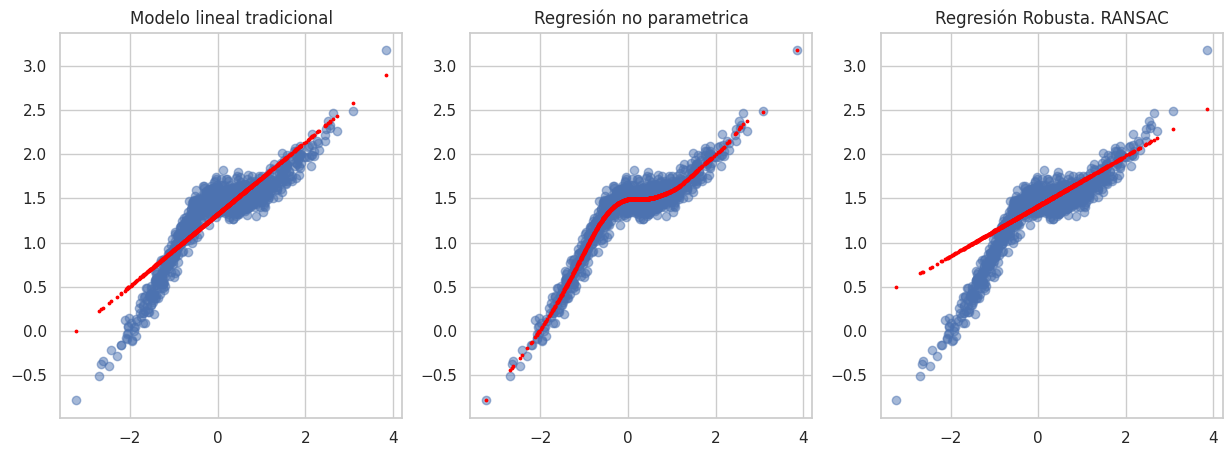

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño del total del figure

# Gráfico de dispersión con datos simulados

axs[0].scatter(x_datos, y_datos_con_ruido, alpha=0.5, label='Data simulada')
axs[0].scatter(x_datos, (b0+b1*x_datos), s=3, color='red', label='Prediccion')
axs[0].set(title='Modelo lineal tradicional')

# Gráfico de dispersión con predicciones
axs[1].scatter(x_datos, y_datos_con_ruido, alpha=0.5, label='Data simulada')
axs[1].scatter(x_datos, pred_no_param, s=3, color='red', label='Prediccion')
axs[1].set(title='Regresión no parametrica')

axs[2].scatter(x_datos_reshape, y_datos_con_ruido, alpha=0.5, label='Data simulada')
axs[2].scatter(x_datos_reshape, pred_ransac, s=3, color='red', label='Prediccion')
axs[2].set(title='Regresión Robusta. RANSAC')

plt.show()

In [ ]:
resultados = pd.concat([resultados, robusta, noparam], ignore_index=True)
resultados

,Modelo,R2,RMSE
0,Regresion Lineal,0.780787,0.044576
1,Regresion Robusta,0.669543,0.067196
2,Regresion No Parametrica,0.950440,0.010078


# Punto 7


*** Resultados para Regresión No Robusta: ***
Coeficiente beta_0 (intercepto): -3.122584624607091
Coeficiente beta_1 (pendiente): 1.0286309627903572
Error absoluto mediano : 0.9221678850745914
Raiz del Error Medio Cuadratico:  1.586522010940056
*** 
Resultados para Regresión Robusta (Método 1): ***
Coeficiente beta_0 (intercepto): -8.497730540568561
Coeficiente beta_1 (pendiente): 1.4641236100406114
Error absoluto mediano (Método 1): 4.0
Raiz del Error Medio Cuadratico:  4.9155087833857465
*** 
Resultados para Regresión Robusta (Método 2): ***
Coeficiente beta_0 (intercepto): -1.0444886103379254
Coeficiente beta_1 (pendiente): 0.931749186452709
Error absoluto mediano (Método 2): 1.385742678074383
Raiz del Error Medio Cuadratico:  2.0613011968041817 



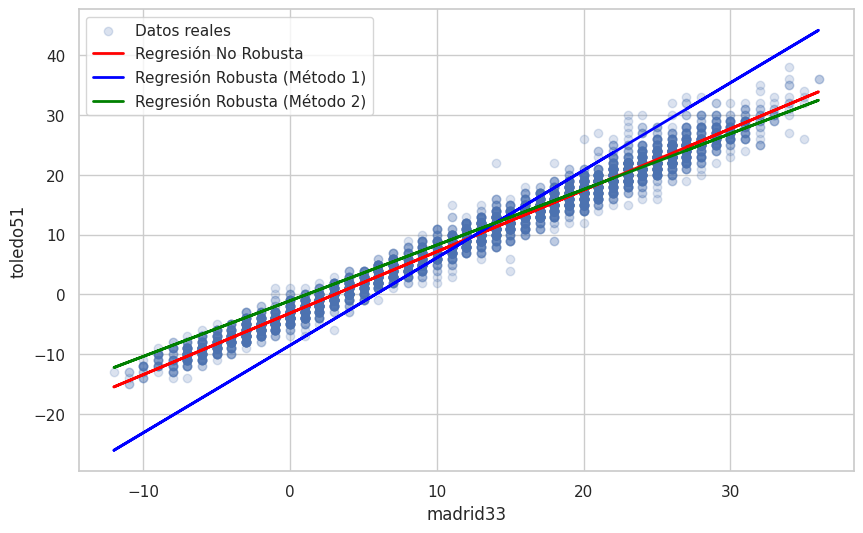


*** Resultados para Regresión No Robusta: ***
Coeficiente beta_0 (intercepto): 2.1500835698027023
Coeficiente beta_1 (pendiente): 0.3158247998751248
Error absoluto mediano : 1.8349299675549489
Raiz del Error Medio Cuadratico:  2.856880604938131
*** 
Resultados para Regresión Robusta (Método 1): ***
Coeficiente beta_0 (intercepto): -2.4807886089813813
Coeficiente beta_1 (pendiente): 0.6165169769989047
Error absoluto mediano (Método 1): 2.150449069003285
Raiz del Error Medio Cuadratico:  3.588966963841308
*** 
Resultados para Regresión Robusta (Método 2): ***
Coeficiente beta_0 (intercepto): -0.4318814084758156
Coeficiente beta_1 (pendiente): 0.4959930240279891
Error absoluto mediano (Método 2): 1.9839720961119554
Raiz del Error Medio Cuadratico:  3.164889194331221 



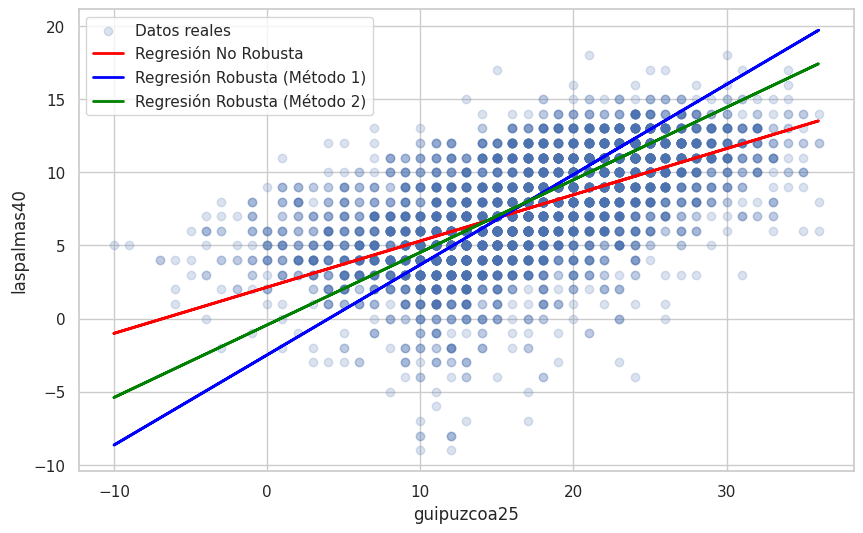

In [ ]:
class RegresionRobusta:
    def __init__(self, df):
        self.df = df

    def columnas_mas_correlacionadas(self):
        # Calcula la matriz de correlación
        correlaciones = self.df.corr().abs()
        # Obtiene las columnas y filas de la matriz de correlación
        columnas = correlaciones.columns
        num_columnas = len(columnas)
        # Encuentra las columnas más correlacionadas
        max_corr = 0
        col1 = None
        col2 = None
        for i in range(num_columnas):
            for j in range(i+1, num_columnas):
                if correlaciones.iloc[i, j] > max_corr:
                    max_corr = correlaciones.iloc[i, j]
                    col1 = columnas[i]
                    col2 = columnas[j]
        return col1, col2, max_corr

    def columnas_menos_correlacionadas(self):
        # Calcula la matriz de correlación
        correlaciones = self.df.corr().abs()
        # Obtiene las columnas y filas de la matriz de correlación
        columnas = correlaciones.columns
        num_columnas = len(columnas)
        # Encuentra las columnas menos correlacionadas
        min_corr = 1  # Inicializamos con el valor máximo de correlación posible
        col1 = None
        col2 = None
        for i in range(num_columnas):
            for j in range(i+1, num_columnas):
                if correlaciones.iloc[i, j] < min_corr:
                    min_corr = correlaciones.iloc[i, j]
                    col1 = columnas[i]
                    col2 = columnas[j]
        return col1, col2, min_corr

    def covariance_matrix(self, X, y):
        # Calcular las medias de X y y
        mean_X = np.mean(X, axis=0)
        mean_y = np.mean(y)
        # Calcular las matrices de diferencias con las medias
        diff_matrix_X = X - mean_X
        diff_vector_y = y - mean_y
        # Calcular la matriz de covarianza
        covariance_matrix = np.dot(diff_matrix_X.T, diff_vector_y) / (X.shape[0] - 1)
        return covariance_matrix

    def comedian_matrix(self, X, y):
        # Calcular las medias de X y y
        median_X = np.median(X, axis=0)
        median_y = np.median(y)
        # Calcular las matrices de diferencias con las medianas
        diff_matrix_X = X - median_X
        diff_vector_y = y - median_y
        # Calcular la matriz de covarianza
        comedian_matrix = np.dot(diff_matrix_X.T, diff_vector_y) / (X.shape[0] - 1)
        return comedian_matrix

    def calcular_coeficientes_regresion(self, X, y):
        # Calcular coeficiente beta_1
        beta_1 = self.covariance_matrix(X, y) / np.var(X)
        # Calcular coeficiente beta_0
        beta_0 = np.mean(y) - beta_1 * np.mean(X)
        return beta_0, beta_1

    def calcular_coeficientes_regresion_robusta_1(self, X, y):
        # Calcular coeficiente beta_1 robusto
        median_x = np.median(X)
        median_y = np.median(y)
        mad_x = np.median(np.abs(X - np.median(X)))
        beta_1 = self.comedian_matrix(X, y) / (mad_x**2) #np.var(X)
        beta_0 = median_y - beta_1 * median_x
        return beta_0, beta_1

    def calcular_coeficientes_regresion_robusta_2(self, col1, col2):
        median_x = np.median(self.df[col1].values)
        median_y = np.median(self.df[col2].values)
        corr = self.df[[col1, col2]].corr(method='kendall').iloc[0, 1]
        cov_matrix = corr
        beta_1 = cov_matrix
        beta_0 = median_y - beta_1 * median_x
        return beta_0, beta_1

    def predecir_valores(self, X, beta_0, beta_1):
        return beta_0 + beta_1 * X

    def root_mean_squared_error(self, y_true, y_pred):
      if len(y_true) != len(y_pred):
          raise ValueError("Las dimensiones de y_true y y_pred no son iguales.")
      n = len(y_true)
      mse = np.sum((y_true - y_pred) ** 2) / n
      return np.sqrt(mse)

    def graficar_resultados(self, max_corr=True):
        # Calcular coeficientes y predecir valores (No Robusto)
        if max_corr:
          col1, col2, _ = self.columnas_mas_correlacionadas()
        else:
          col1, col2, _ = self.columnas_menos_correlacionadas()

        X = self.df[col1].values
        y = self.df[col2].values
        beta_0_nr, beta_1_nr = self.calcular_coeficientes_regresion(X, y)
        y_pred_nr = self.predecir_valores(X, beta_0_nr, beta_1_nr)
        error = np.median(np.abs(y - y_pred_nr))
        errorr = self.root_mean_squared_error(y, y_pred_nr)

        # Calcular coeficientes y predecir valores (Robusto 1)
        beta_0_r1, beta_1_r1 = self.calcular_coeficientes_regresion_robusta_1(X, y)
        y_pred_r1 = self.predecir_valores(X, beta_0_r1, beta_1_r1)
        error_r1 = np.median(np.abs(y - y_pred_r1))
        error_r11 = self.root_mean_squared_error(y, y_pred_r1)

        # Calcular coeficientes y predecir valores (Robusto 2)
        beta_0_r2, beta_1_r2 = self.calcular_coeficientes_regresion_robusta_2(col1, col2)
        y_pred_r2 = self.predecir_valores(X, beta_0_r2, beta_1_r2)
        error_r2 = np.median(np.abs(y - y_pred_r2))
        error_r22 = self.root_mean_squared_error(y, y_pred_r2)

        print("="*160,"\n")

        print("*** Resultados para Regresión No Robusta: ***")
        print("Coeficiente beta_0 (intercepto):", beta_0_nr)
        print("Coeficiente beta_1 (pendiente):", beta_1_nr)
        print("Error absoluto mediano :", error)
        print("Raiz del Error Medio Cuadratico: ", errorr)

        print("*** \nResultados para Regresión Robusta (Método 1): ***")
        print("Coeficiente beta_0 (intercepto):", beta_0_r1)
        print("Coeficiente beta_1 (pendiente):", beta_1_r1)
        print("Error absoluto mediano (Método 1):", error_r1)
        print("Raiz del Error Medio Cuadratico: ", error_r11)

        print("*** \nResultados para Regresión Robusta (Método 2): ***")
        print("Coeficiente beta_0 (intercepto):", beta_0_r2)
        print("Coeficiente beta_1 (pendiente):", beta_1_r2)
        print("Error absoluto mediano (Método 2):", error_r2)
        print("Raiz del Error Medio Cuadratico: ", error_r22, "\n")

        # Gráfica
        plt.figure(figsize=(10,6))
        plt.scatter(X, y, label='Datos reales', alpha=0.2)
        plt.plot(X, y_pred_nr, color='red', label='Regresión No Robusta', lw=2)
        plt.plot(X, y_pred_r1, color='blue', label='Regresión Robusta (Método 1)', lw=2)
        plt.plot(X, y_pred_r2, color='green', label='Regresión Robusta (Método 2)', lw=2)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()
        plt.grid(True)
        plt.show()

# Cargar datos
path = '/content/Temperaturas.xlsx'
df = pd.read_excel(path)
df = df.drop(df.columns[0:4], axis=1)

# Crear objeto de la clase RegresionRobusta
regresion = RegresionRobusta(df)

# Graficar resultados
regresion.graficar_resultados(max_corr=True)
regresion.graficar_resultados(max_corr=False)

# Punto 8

In [ ]:
data = pd.read_excel('/content/Temperaturas.xlsx')

# Extraer temperaturas de Las Palmas y Guipúzcoa
temperaturas_laspalmas = data['laspalmas40']
temperaturas_guipuzcoa = data['guipuzcoa25']

resultados_laspalmas = {}
resultados_guipuzcoa = {}

# Realizar el test de Mann-Whitney con cada provincia para Las Palmas y Guipúzcoa
for provincia in data.columns[4:]:
    if provincia not in ['laspalmas40', 'guipuzcoa25']:

        # Test con Las Palmas
        stat_lp, p_valor_lp = mannwhitneyu(data[provincia], temperaturas_laspalmas, alternative='two-sided')
        resultados_laspalmas[provincia] = (stat_lp, p_valor_lp)

        # Test con Guipúzcoa
        stat_gp, p_valor_gp = mannwhitneyu(data[provincia], temperaturas_guipuzcoa, alternative='two-sided')
        resultados_guipuzcoa[provincia] = (stat_gp, p_valor_gp)

# Convertir los diccionarios a DataFrames para facilitar la manipulación
df_resultados_laspalmas = pd.DataFrame.from_dict(resultados_laspalmas, orient='index', columns=['Stat', 'P-valor'])
df_resultados_guipuzcoa = pd.DataFrame.from_dict(resultados_guipuzcoa, orient='index', columns=['Stat', 'P-valor'])

# Filtrar los resultados significativos y no significativos para Las Palmas
significativos_laspalmas = df_resultados_laspalmas[df_resultados_laspalmas['P-valor'] < 0.05]
no_significativos_laspalmas = df_resultados_laspalmas[df_resultados_laspalmas['P-valor'] >= 0.05]

# Filtrar los resultados significativos y no significativos para Guipúzcoa
significativos_guipuzcoa = df_resultados_guipuzcoa[df_resultados_guipuzcoa['P-valor'] < 0.05]
no_significativos_guipuzcoa = df_resultados_guipuzcoa[df_resultados_guipuzcoa['P-valor'] >= 0.05]

# Mostrar las tablas (opcionalmente podrías guardarlas en archivos .csv o .xlsx)
print("Diferencias Significativas - Las Palmas:")
print(significativos_laspalmas)
print("\nSin Diferencias Significativas - Las Palmas:")
print(no_significativos_laspalmas)

print("\nDiferencias Significativas - Guipúzcoa:")
print(significativos_guipuzcoa)
print("\nSin Diferencias Significativas - Guipúzcoa:")
print(no_significativos_guipuzcoa)


Diferencias Significativas - Las Palmas:
                     Stat        P-valor
alava5         23900727.5   0.000000e+00
albacete6      19257079.5  2.148433e-145
alicante7      16760750.0   3.260106e-26
almeria8       17549977.5   2.766722e-53
avila9         23000791.5   0.000000e+00
badajoz10      16579277.0   2.321432e-21
baleares11     19000483.5  1.044941e-128
barcelona12    21446322.0   0.000000e+00
burgos13       23251446.0   0.000000e+00
caceres14      18601209.0  1.577815e-104
cadiz15        20828275.5  1.719162e-271
castellon16    17982857.0   2.723495e-72
ceuta17        22342570.0   0.000000e+00
coruña19       26874119.0   0.000000e+00
creal20        18176379.0   1.104630e-81
cuenca21       20653223.5  4.223797e-255
gerona22       19983492.5  1.001024e-198
granada23      17929966.5   9.384526e-70
guadalajara24  21700206.0   0.000000e+00
huelva26       16495817.5   2.519708e-19
huesca27       18333098.5   8.506053e-90
jaen28         19011668.0  2.600334e-129
leon29         2

# Punto 9

In [ ]:
ruta="/content/accidentes_barrio.csv"
data=pd.read_csv(ruta)
data

,BARRIO,Hora_0,Hora_1,Hora_2,Hora_3,Hora_4,Hora_5,Hora_6,Hora_7,Hora_8,...,Hora_14,Hora_15,Hora_16,Hora_17,Hora_18,Hora_19,Hora_20,Hora_21,Hora_22,Hora_23
0,AguasFrias,1.0,1.0,2.0,1.0,2.0,2.0,6.0,0.0,5.0,...,3.0,4.0,0.0,5.0,1.0,3.0,8.0,6.0,4.0,4.0
1,AldeaPabloVI,3.0,3.0,0.0,1.0,2.0,3.0,4.0,1.0,3.0,...,3.0,4.0,2.0,3.0,5.0,1.0,5.0,2.0,2.0,0.0
2,Alejandria,3.0,11.0,3.0,4.0,8.0,4.0,23.0,17.0,24.0,...,28.0,26.0,21.0,16.0,12.0,17.0,14.0,9.0,13.0,4.0
3,AlejandroEchavarria,14.0,13.0,21.0,9.0,19.0,18.0,40.0,49.0,36.0,...,23.0,35.0,28.0,39.0,40.0,40.0,35.0,24.0,21.0,15.0
4,AlfonsoLopez,13.0,13.0,6.0,18.0,16.0,34.0,76.0,66.0,54.0,...,48.0,53.0,45.0,58.0,50.0,53.0,45.0,40.0,26.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,Villatina,8.0,6.0,7.0,8.0,8.0,11.0,23.0,18.0,15.0,...,15.0,13.0,19.0,22.0,16.0,27.0,19.0,19.0,12.0,12.0
312,Yolombo,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
313,ÁreadeExpansionAltosdeCalasanz,1.0,2.0,1.0,1.0,1.0,2.0,9.0,8.0,7.0,...,4.0,2.0,7.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0
314,ÁreadeExpansionPajarito,5.0,9.0,9.0,4.0,9.0,29.0,59.0,49.0,40.0,...,25.0,29.0,32.0,30.0,24.0,35.0,33.0,24.0,19.0,10.0


In [ ]:
# Extraer los datos numéricos
datos_horas = data.iloc[:, 1:].values
N=datos_horas.shape[0]

# Crear el vector de horas del día
t = np.arange(24)

### Convertir a data funcional
fd = fda.FDataGrid(data_matrix=datos_horas, grid_points=t)

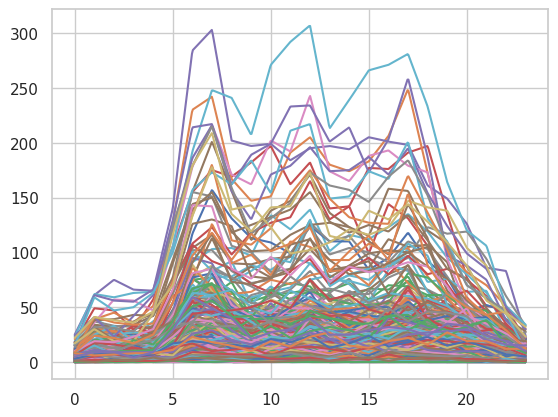

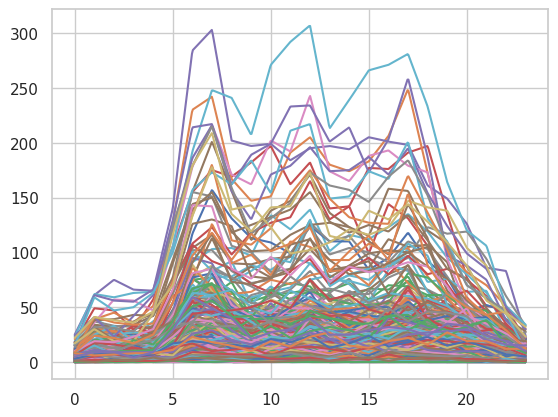

In [ ]:
### Graficar las curvas
fd.plot()

In [ ]:
### Medida de produndidad de Fraiman Muniz
depth = fda.exploratory.depth.IntegratedDepth()
depth(fd)

array([0.75056182, 0.73321409, 0.88956155, 0.74784443, 0.65045405,
       0.77450238, 0.92439461, 0.79566823, 0.89285223, 0.88100807,
       0.88960741, 0.91660934, 0.70688864, 0.6371652 , 0.92218171,
       0.8832095 , 0.79803018, 0.89783985, 0.91225234, 0.86836131,
       0.81709778, 0.72173684, 0.69286599, 0.52220923, 0.81697166,
       0.87575674, 0.61172262, 0.62392222, 0.8750344 , 0.54976151,
       0.81129609, 0.93071225, 0.73604614, 0.86972574, 0.76022748,
       0.73839662, 0.74291414, 0.66355944, 0.92692855, 0.93449596,
       0.55918639, 0.86348835, 0.90014447, 0.68625023, 0.68886443,
       0.61773069, 0.85091038, 0.78085443, 0.9365942 , 0.63249862,
       0.8850211 , 0.5151463 , 0.63752064, 0.70356357, 0.50550358,
       0.53359475, 0.76878096, 0.54549624, 0.71175014, 0.86662998,
       0.84675977, 0.90987892, 0.82185608, 0.56370391, 0.90627866,
       0.61729499, 0.61275454, 0.57799028, 0.68231746, 0.68959824,
       0.92410796, 0.87602045, 0.82199367, 0.68058613, 0.88992

Text(0.5, 1.0, 'Visualización de Datos Funcionales Profundidad Máxima')

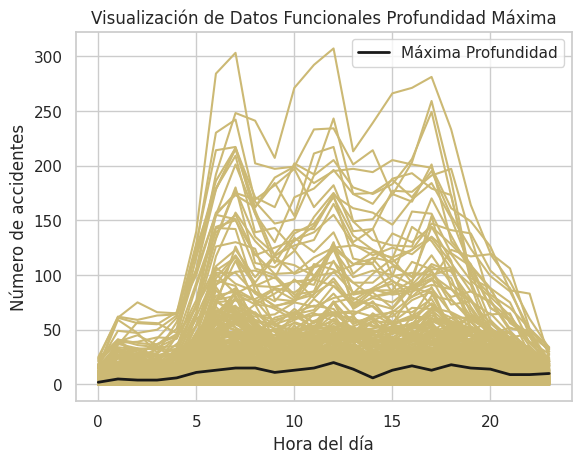

In [ ]:
plt.figure('Functional data plot')
for i in range(N):
    plt.plot(t, datos_horas[i], c='y')
indice_max_profundidad = np.argmax(depth(fd))
plt.plot(t, datos_horas[indice_max_profundidad], c='k', linewidth=2, label='Máxima Profundidad')
plt.legend()
plt.xlabel('Hora del día')
plt.ylabel('Número de accidentes')
plt.title('Visualización de Datos Funcionales Profundidad Máxima')

In [ ]:
# Añadir los resultados al DataFrame
data['Profundidad'] = depth(fd)

# Ordenar y seleccionar los 10 barrios con mayor profundidad
top_10_barrios = data[['BARRIO', 'Profundidad']].sort_values(by='Profundidad', ascending=False).head(10)
print(top_10_barrios)

                   BARRIO  Profundidad
203              MoscuNo1     0.947980
167           LasMercedes     0.940114
153             LaPradera     0.938337
114              Granizal     0.938108
270          SimonBolivar     0.937087
48      CalasanzParteAlta     0.936594
263           SantaMonica     0.936181
310       VilladelSocorro     0.934886
39      BosquesdeSanPablo     0.934496
208  NuevaVilladelaIguana     0.931079


# Punto 10

In [ ]:
# Ordenar los barrios por profundidad en orden ascendente para identificar el 5% mayor como outliers
data_sorted_by_depth = data.sort_values(by='Profundidad', ascending=True)
num_outliers = int(len(data_sorted_by_depth) * 0.05)
outliers = data_sorted_by_depth[['BARRIO', 'Profundidad']].head(num_outliers)
print(outliers)

                   BARRIO  Profundidad
129          LaCandelaria     0.502477
54                 Caribe     0.505504
184     LosConquistadores     0.513702
224       PerpetuoSocorro     0.515100
51              CampoAmor     0.515146
23            BarrioColon     0.522209
239             SanBenito     0.523516
116             Guayaquil     0.528538
257               SantaFe     0.530144
308            VillaNueva     0.532827
55        CarlosERestrepo     0.533595
241              SanDiego     0.537929
288  TerminaldeTransporte     0.539030
205              Naranjal     0.542653
57               Castilla     0.545496


Text(0.5, 1.0, 'Visualización de Datos Funcionales con Outliers y Profundidad Máxima')

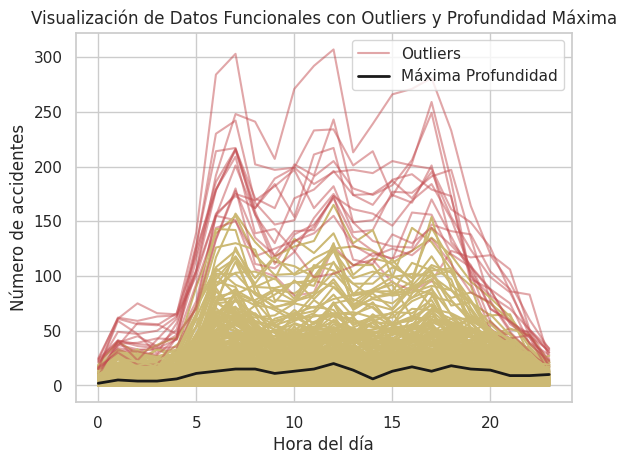

In [ ]:
outliers_indices = data_sorted_by_depth.head(num_outliers).index
plt.figure('Functional data plot')
for i in range(N):
    if i in outliers_indices:
        plt.plot(t, datos_horas[i], c='r', alpha=0.5, label='Outliers' if 'Outliers' not in plt.gca().get_legend_handles_labels()[1] else "")  # Outliers en rojo
    else:
        plt.plot(t, datos_horas[i], c='y')  # Otros barrios en amarillo
indice_max_profundidad = np.argmax(depth(fd))
plt.plot(t, datos_horas[indice_max_profundidad], c='k', linewidth=2, label='Máxima Profundidad') # Máxima profundidad en negro
plt.legend()
plt.xlabel('Hora del día')
plt.ylabel('Número de accidentes')
plt.title('Visualización de Datos Funcionales con Outliers y Profundidad Máxima')

# Punto 11

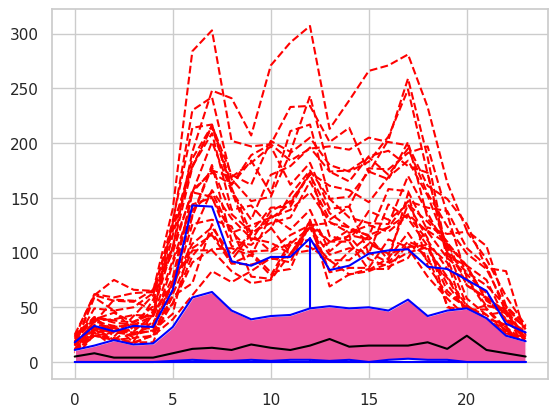

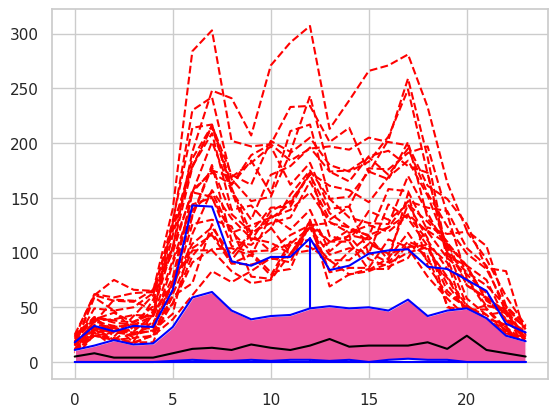

In [ ]:
fd = fda.FDataGrid(data_matrix=datos_horas, grid_points=t)
fdBoxplot = Boxplot(fd)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [ ]:
nombres_barrios = data.iloc[:, 0].values  # Nombres de los barrios
# Calculando el IQR para identificar outliers
Q1 = np.percentile(datos_horas, 25, axis=0)  # 25th percentile
Q3 = np.percentile(datos_horas, 75, axis=0)  # 75th percentile
IQR = Q3 - Q1

# Umbrales para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificando los outliers
outliers = np.where((datos_horas < np.tile(lower_bound, (datos_horas.shape[0], 1))) |
                    (datos_horas > np.tile(upper_bound, (datos_horas.shape[0], 1))))
# Listar los nombres de los barrios correspondientes a los outliers
outlier_barrios = set(nombres_barrios[outliers[0]])  # Usar un conjunto para evitar duplicados
outliers_df = pd.DataFrame(sorted(list(outlier_barrios)), columns=["Barrios Outliers"])
outliers_df

,Barrios Outliers
0,BarrioColon
1,Belen
2,Boston
3,CabeceraSanAntoniodePrado
4,CalleNueva
5,CampoAmor
6,CampoValdesNo1
7,CampoValdesNo2
8,Caribe
9,CarlosERestrepo
